In [1]:
import pandas as pd
import healpy as hp
import numpy as np
import ligo.skymap
import argparse
import matplotlib.pyplot as plt

from matplotlib import rcParams
from pathlib import Path
from ligo.skymap import io, kde, postprocess
from ligo.skymap.plot.marker import reticle

import h5py


In [3]:
f1 = h5py.File("/group/pmc005/cchatterjee/Localization_output_files/Fixed_NSIDE/Injection_run_BNS_new_ResNet-34.hdf", "r")
probs = f1["Probabilities"][()]
ra_preds = f1["RA_samples"][()]
dec_preds = f1["Dec_samples"][()]
ra_test = f1["RA_test"][()]
dec_test = f1["Dec_test"][()]

f1.close()


In [4]:
ra_preds = np.where(ra_preds > 2.0*np.pi, 2.0*np.pi, ra_preds)
ra_preds = np.where(ra_preds < 0.0, 0.0, ra_preds)


dec_preds = np.where(dec_preds > np.pi/2, np.pi/2, dec_preds)
dec_preds = np.where(dec_preds < -np.pi/2, -np.pi/2, dec_preds)


In [5]:
pts = np.stack([ra_preds, dec_preds], axis=2)


In [7]:
sky_posterior = []

for i in range(10):
    sky_posterior.append(kde.Clustered2DSkyKDE(pts[i], trials=1, jobs=5))


In [8]:
hpmap = []

for i in range(10):
    hpmap.append(sky_posterior[i].as_healpix())


adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
a

In [9]:
for i in range(10):
    io.write_sky_map('skymaps/Test_GW170817_'+str(i)+'_1.fits', hpmap[i], nest=True)


In [10]:
skymap = []

for i in range(10):
    s, metadata = io.fits.read_sky_map('skymaps/Test_GW170817_'+str(i)+'_1.fits', nest=None)
    skymap.append(s)
    

In [19]:
#ax = plt.axes(projection="astro hours mollweide")
#ax.grid()

cl = []
area_90 = []
area_50 = []
search_area = []

eps = 1e-5

for i in range(10):
    # Convert to probability per square degree
    nside = hp.npix2nside(len(skymap[i]))
    deg2perpix = hp.nside2pixarea(nside, degrees=True)
    probperdeg2 = skymap[i] / deg2perpix
    
    event_ra = ra_test[i]
    event_de = dec_test[i]

    vmax = probperdeg2.max()
    vmin = probperdeg2.min()
    
    confidence_levels = 100 * postprocess.find_greedy_credible_levels(skymap[i])
    cl.append(confidence_levels[hp.ang2pix(nside,-event_de+np.pi/2,event_ra, nest=True)]) 
    
    area_90.append(np.sum(confidence_levels <= 90) * hp.nside2pixarea(nside, degrees=True) + eps)
    area_50.append(np.sum(confidence_levels <= 50) * hp.nside2pixarea(nside, degrees=True) + eps)
    
    search_area.append(np.sum(confidence_levels <= cl[i]) * hp.nside2pixarea(nside, degrees=True) + eps)  
    

In [20]:
from tabulate import tabulate

table = [["90%",np.min(area_90),np.argmin(area_90)],
         ["50%",np.min(area_50),np.argmin(area_50)],
         ["Searched Area",np.min(search_area),np.argmin(search_area)]]

print(tabulate(table, headers=["Percentage", "Minimum area", "Minimum index"]))
  

Percentage       Minimum area    Minimum index
-------------  --------------  ---------------
90%                  9.1929                  8
50%                  2.67526                 8
Searched Area        0.554075                0


Text(0.5, 0, 'Area in log(deg^2)')

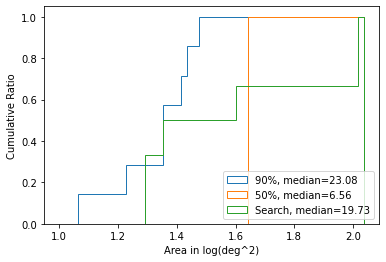

In [13]:
plt.hist(np.log10(area_90),50,range=(1,np.max(np.log10(search_area))),cumulative=True,histtype='step',density=True,label='90%, median='+str(round(np.median(area_90),2)))
plt.hist(np.log10(area_50),50,range=(1,np.max(np.log10(search_area))),cumulative=True,histtype='step',density=True,label='50%, median='+str(round(np.median(area_50),2)))
plt.hist(np.log10(search_area),50,range=(1,np.max(np.log10(search_area))),cumulative=True,histtype='step',density=True,label='Search, median='+str(round(np.median(search_area),2)))


plt.legend(loc=4)
plt.ylabel('Cumulative Ratio')
plt.xlabel('Area in log(deg^2)')


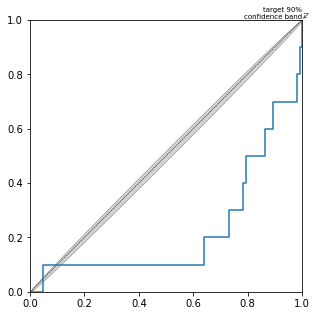

In [26]:
cl = np.array(cl)
cl = cl/100

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='pp_plot')

ax.add_confidence_band(len(ra_test),alpha=0.90) # Add 90% confidence band
ax.add_diagonal() # Add diagonal line
#ax.add_lightning(len(ra_test), 20) # Add some random realizations of n samples
ax.add_series(cl) # Add our data


In [9]:
skymap, metadata = io.fits.read_sky_map('skymaps/Test_GW170817_0_1.fits', nest=None)
nside = hp.npix2nside(len(skymap))


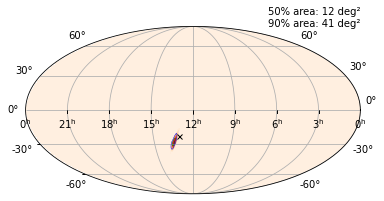

In [10]:
from astropy.coordinates import SkyCoord
# Convert to probability per square degree
deg2perpix = hp.nside2pixarea(nside, degrees=True)
probperdeg2 = skymap / deg2perpix

ax = plt.axes(projection="astro hours mollweide")
ax.grid()

event_ra = ra_test[0]
event_de = dec_test[0]

vmax = probperdeg2.max()
vmin = probperdeg2.min()
ax.imshow_hpx((probperdeg2, 'ICRS'), nested=True, vmin=vmin, vmax=vmax, cmap='cylon')
confidence_levels = 100 * postprocess.find_greedy_credible_levels(skymap)
contours = ax.contour_hpx((confidence_levels, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])
#cs = postprocess.contour(m, [50,90], degrees=True)
ax.plot_coord(SkyCoord(event_ra, event_de, unit='rad'), 'x',markeredgecolor='black', markersize=5)

text = []
pp = np.round([50,90]).astype(int)
#ii = np.round(np.searchsorted(np.sort(cls),[50,90]) * deg2perpix).astype(int)
ii_90 = np.sum(confidence_levels <= 90) * hp.nside2pixarea(nside, degrees=True)
ii_50 = np.sum(confidence_levels <= 50) * hp.nside2pixarea(nside, degrees=True)
ii = np.round([ii_50,ii_90]).astype(int)
for i, p in zip(ii, pp):
            # FIXME: use Unicode symbol instead of TeX '$^2$'
            # because of broken fonts on Scientific Linux 7.
            text.append(u'{:d}% area: {:d} deg²'.format(p, i, grouping=True))
ax.text(1, 1, '\n'.join(text), transform=ax.transAxes, ha='right')
#ax.figure.savefig('Localization_after_autoencoder/GWOSC_files_from_autoencoder_final/Localization_plots/CNN_MDN_GW170823_test_NSIDE64.png',dpi=150)
ax.figure.savefig('Preds_test_0.png',dpi=150)


In [1]:
import h5py

f1 = h5py.File("Adaptive_NSIDE/Injection_run_BNS_3_det_adaptive_SNR-10to20.hdf", "r")
probs = f1["Probabilities"][()]
ra_test = f1["RA_test"][()]
dec_test = f1["Dec_test"][()]


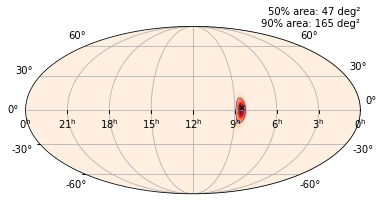

In [8]:
# Plot skymap

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('tkagg')
from ligo.skymap import postprocess
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import healpy as hp
from ligo.skymap.io import fits
from ligo.skymap import plot
from ligo.skymap import postprocess
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.pyplot import cm
import matplotlib


def my_cl(array,value):
    ratio=1.0
    arg = np.argsort(-array)
    total = np.sum(array)
    part=0.0
    for i in arg:
#        part = part + array[i]
        if array[i]<value:
            ratio = part/total
            break
        else:
            part = part + array[i]
    
    return ratio


nside=32
npix=hp.nside2npix(nside)
theta,phi = hp.pixelfunc.pix2ang(nside,np.arange(npix))
#ra_pix = phi
#de_pix = -theta + np.pi/2.0

deg2perpix = hp.nside2pixarea(nside, degrees=True)

#sector_data = np.loadtxt('Probabilities_1', skiprows=1)
#prob = np.loadtxt('Localization_after_autoencoder/GWOSC_files_from_autoencoder_final/Localization_preds/CNN_MDN_GW170823_test_NSIDE64.txt')
prob = probs[0]


cls = 100 * postprocess.find_greedy_credible_levels(prob)

ax = plt.axes(projection='astro hours mollweide')
ax.grid()
event_ra = ra_test[0]
event_de = dec_test[0]

value = hp.pixelfunc.get_interp_val(prob,event_de,event_ra)
projector  = hp.projector.MollweideProj()
#x1,y1 = projector.ang2xy(np.array([event_de,event_ra]))
img = ax.imshow_hpx(prob, vmin=prob.min(), vmax=prob.max(),cmap='cylon')
cs = ax.contour_hpx((cls, 'ICRS'),linewidths=0.5, levels=[0.5*np.sum(prob)*100,0.9*np.sum(prob)*100],colors=['green','blue'])
m = theta
cs = postprocess.contour(m, [50,90], degrees=True)
ax.plot_coord(SkyCoord(event_ra, event_de, unit='rad'), 'x',markeredgecolor='black', markersize=5)
text = []
cl = my_cl(prob,value)*100
pp = np.round([50,90]).astype(int)
#ii = np.round(np.searchsorted(np.sort(cls),[50,90]) * deg2perpix).astype(int)
ii_90 = np.sum(cls <= 90*np.sum(prob)) * hp.nside2pixarea(nside, degrees=True)
ii_50 = np.sum(cls <= 50*np.sum(prob)) * hp.nside2pixarea(nside, degrees=True)
ii = np.round([ii_50,ii_90]).astype(int)
for i, p in zip(ii, pp):
            # FIXME: use Unicode symbol instead of TeX '$^2$'
            # because of broken fonts on Scientific Linux 7.
            text.append(u'{:d}% area: {:d} deg²'.format(p, i, grouping=True))
ax.text(1, 1, '\n'.join(text), transform=ax.transAxes, ha='right')
#ax.figure.savefig('Localization_after_autoencoder/GWOSC_files_from_autoencoder_final/Localization_plots/CNN_MDN_GW170823_test_NSIDE64.png',dpi=150)
ax.figure.savefig('Preds_test_0.png',dpi=150)


In [35]:
f1 = h5py.File("/group/pmc005/cchatterjee/SNR_time_series_sample_files/default_snr_series_GW170817_BNS_snr_10-20_test.hdf", 'r')


In [36]:
group_test = f1['omf_injection_snr_samples']
        
data_h1_test = group_test['h1_snr']
data_l1_test = group_test['l1_snr']
data_v1_test = group_test['v1_snr']
        
h1_test_real = np.zeros([2000,410])
l1_test_real = np.zeros([2000,410])
v1_test_real = np.zeros([2000,410])
        
h1_test_imag = np.zeros([2000,410])
l1_test_imag = np.zeros([2000,410])
v1_test_imag = np.zeros([2000,410])
        
for i in range(2000):
    h1_test_real[i] = abs(group_test['h1_snr'][str(i)][()][1840:2250] )
    l1_test_real[i] = abs(data_l1_test[str(i)][()][1840:2250] )
    v1_test_real[i] = abs(data_v1_test[str(i)][()][1840:2250] )
    
    h1_test_imag[i] = np.imag(data_h1_test[str(i)][()][1840:2250] )
    l1_test_imag[i] = np.imag(data_l1_test[str(i)][()][1840:2250] )
    v1_test_imag[i] = np.imag(data_v1_test[str(i)][()][1840:2250] )
        
f1.close()
        
h1_test_real = h1_test_real[:,:,None]
l1_test_real = l1_test_real[:,:,None]
v1_test_real = v1_test_real[:,:,None]
    
h1_test_imag = h1_test_imag[:,:,None]
l1_test_imag = l1_test_imag[:,:,None]
v1_test_imag = v1_test_imag[:,:,None]
        

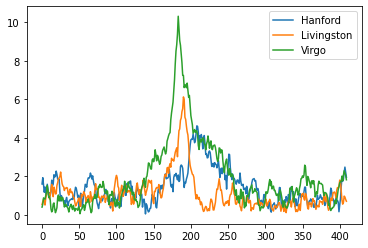

In [58]:
plt.plot(np.abs(h1_snr_series[0]), label='Hanford')
plt.plot(np.abs(l1_snr_series[0]), label='Livingston')
plt.plot(np.abs(v1_snr_series[0]), label='Virgo')

plt.legend()


In [40]:
f1.close()
